# Mono (Single) Camera Calibration

Kevin J. Walchko created 27 July 2017

----

Most useful robotics work requires calibrated camera in order to properly use the information distilled from each image. This will cover calibration of a single camera, but the basics apply to stereo calibration.


## References

- [OpenCV 3.3 Docs](http://docs.opencv.org/3.3.0/)
- [OpenCV 2.4 Camera Calibration](http://docs.opencv.org/2.4/modules/calib3d/doc/camera_calibration_and_3d_reconstruction.html)
- [Scott's work - I can't find the link again](tbd)
- [skimage ransac library](http://scikit-image.org/docs/dev/api/skimage.measure.html#skimage.measure.ransac)
- [Fractal Target: Camera Calibration for Light Fields and Camera Arrays](http://lightfieldgroup.iwr.uni-heidelberg.de/?page_id=1066)
- [Circle Grid Fractal Pattern for Calibration at Different Camera Zoom Levels](http://www.k2.t.u-tokyo.ac.jp/mvf/FractalCalibrationPattern/index-e.html)
- [Robotics with ROS](ros-developer.com)

## Setup

In [1]:
%matplotlib inline 

In [2]:
import numpy as np
import cv2
import time
import pickle
from pprint import pprint
import json
from glob import glob
from matplotlib import pyplot as plt # this lets you draw inline pictures in the notebooks
from matplotlib.ticker import NullFormatter
import pylab                                 
pylab.rcParams['figure.figsize'] = (10.0, 18.0)

In [3]:
from enum import Enum

Markers = Enum('Markers', 'checkerboard circle acircle aruco charuco')

In [4]:
def get_images(path, gray=False):
    """
    Given a path, it reads all images. This uses glob to grab file names
    and excepts wild cards *
    Ex. getImages('./images/*.jpg')
    """
    imgs = []
    files = glob(path)

    print("Found {} images at {}".format(len(tuple(files)), path))
    # print('-'*40)

    for i, f in enumerate(files):
        img = cv2.imread(f)
        if img is None:
            print('>> Could not read: {}'.format(f))
        else:
            if gray and len(img.shape) > 2:
               img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
            print("[{}]:{} ({}, {})".format(i, f, *img.shape))
            h, w = img.shape[:2]
            imgs.append(img)
    # print('-'*40)
    return imgs

<img src="./images/output-5.png" />

- lenses made today generally allow the light rays to pass straight through without adversly affecting their path. However, depending on your application, you may need to calibrate your camera to produce a better picture. Stereo vision and video odometry are two such applications where sub pixel performance needs to be good in order to obtain good results.

<img src="./images/fstop.jpg" />

# Camera Model

The functions in this section use a so-called pinhole camera model. In this model, a scene view is formed by projecting 3D points into the image plane using a perspective transformation.

![Pinhole Camera Model](images/pinhole_camera_model.png)

\begin{eqnarray}
  s p' = A[R|t]P' \\
  s \begin{bmatrix} u\\ v\\ 1 \end{bmatrix} = 
  \begin{bmatrix}
    f_x & 0 & c_x \\
    0 & f_y & c_y \\
    0 & 0 & 1
  \end{bmatrix}
  \begin{bmatrix} R_{3x3} & t_{xyz} \end{bmatrix}
  \begin{bmatrix} X \\ Y \\ Z \\ 1 \end{bmatrix}
\end{eqnarray}

where:

- P(X, Y, Z) are the coordinates of a 3D point in the world coordinate space
- p(u, v) are the coordinates of the projection point in pixels
- A is a camera matrix, or a matrix of **intrinsic** parameters (think internal parameters)
- (cx, cy) is a principal point that is usually at the image center
- fx, fy are the focal lengths expressed in pixel units
- [R|t] are the **extrinsic** parameters (think external parameters)

The matrix of intrinsic parameters does not depend on the scene viewed. So, once estimated, it can be re-used as long as the focal length is fixed (in case of zoom lens). The joint rotation-translation matrix [R|t] is called a matrix of extrinsic parameters. It is used to describe the camera motion around a static scene. That is, [R|t] translates coordinates of a point (X, Y, Z) to a coordinate system, fixed with respect to the camera. The transformation above is equivalent to the following (when $z \ne 0$ ):

\begin{eqnarray}
  \begin{bmatrix} x \\ y \\ z \end{bmatrix} = R_{3x3}
  \begin{bmatrix} X \\ Y \\ Z \end{bmatrix} + t_{xyz} \\
  x' = \frac{x}{z} \\
  y' = \frac{y}{z} \\
  u = f_x*x'+c_x \\
  v = f_y*y'+c_y
\end{eqnarray}

## Focal Length

![](images/focal-length.jpg)

The focal length of a camera is an important aspect for a couple of reasons.

1. A properly designed camera has a focal length which ensures your entire image plane is illuminated with light
1. Your focal length also determines your field of view.

$$
\alpha = 2 \cdot arctan2(w, 2f) \\
f = \frac{w}{2} \cot( \frac{\alpha}{2} )
$$

A lot of cameras have a fixed focal length, like our cell phone camera used with the raspberry pi, but some cameras have a mechanical zoom feature which narrows the FOV and allow more pixels across a smaller area.

All cameras have a digital zoom, where they smartly average pixels together to simulate a mechanical zoom, but it really isn't a zoom. You are better off taking the native image and then "zooming" and cropping the image in software later.

## Distortions

If everything was perfect, the red lines in the image below would lie neatly on the checkerboard.

![](images/distortion.jpg)

However, there are always little distortions in the lense (or misalignments) that break this model. Typically you must correct for radial ($k_{1-6}$) and tangential ($p_{1-2}$) distortions coefficients which effect the $x'$ and $y'$ terms in a nonlinear manor. The pictures below show the barrel distortion (typically $k_1 > 0$) and pincushion distortion (typically $k_1 < 0$).

![](images/distortion_examples.png)

## Calibration

![](images/cal-images.jpg)

So how do we do this? The calibration code for the checkerboard does:

1. Converts image to grayscale
2. Searches for the intersections of the chessboard and should find 9x6 of them (i.e., 54 intersections)
3. Using homography and knowing that we are using a chessboard, it then uses an algorithm, typically RANSAC, to figure out the how the calibration target was warped in order to match the image.
    1. Note, there are other camera targets besides the classic chessboard. 
4. It then returns your calculated camera matrix and distortion parameters (the k's mentioned above) which allow you to remove distortion from an image

## Calibration Patterns

What do you want in a calibration patter? Well

- 

OpenCV supports several patterns:

<span>
  <img src="patterns/checkerboard.jpg" width="30%"> 
  <img src="patterns/symetric-circles.jpg" width="30%"> 
  <img src="patterns/asymetric-circles.jpg" width="30%">  
</span>

Generally, the checkerboard pattern performs the best. Mainly because the algorithms are simple and effective to finding the intersections of the black/white squares. The circles use a more complex algorithm and have to determine the center of mass correctly. Unfortunately, camera lens distortion can cause the centers to be off just a little and the calibration not as good as the checkerboard.

<img src="patterns/intersection.png" width="30%">


### Other patterns

Now the choice of pattern is a complex thing, but involves camera FOV. You want to:

- cover the entire frame
- move the pattern over th entire calibration volume (in 3D space, this is a cone)
- Angle the patter with respect to the focal/principle axis
- Uniformly distribute the collected images over the calibration volume (not just the center) 

As you move the target farther/closer to the camera, the pixel resolution changes for the features you are trying to detect. Some suggest a feature (like a checkerboard box) should be at least 10 pixels across. The patterns we looked at so far are only one size. So there are other patterns that try to adapt and help you with the above.

<span>
  <img src="patterns/other.png" width="50%"> 
  <img src="patterns/recursive.png" width="60%"> 
</span>

Additionally, the marker type of boards also lend themselves to helping you understand the surface shape of the target. You can tpyically determine orientation and an ID of markers. You can also typically calibrate when some of the markers are occulded or not recognized, because each corner is associated with an ID number. The classic checkerboard tends to be, if you didn't detect all corners, then throw out the image, because I don't know (no ID) which intersections (corners) were not detected. 

There are even calibration targets setup for satellites to calibrate the cameras. The one below was for satellite to be able to calibrate their sensor/output images to the appropriate [NIIRS](https://en.wikipedia.org/wiki/NIIRS).

<span>
  <img src="patterns/space-cal.jpg" width="50%"> 
</span>


## Performance

How do you know you did a good job? The function `cv2.calibrateCamera()` returns an RMS value in pixels, so:

- **BAD:** RMS > 1.0px
- **OK:** RMS < 1.0px
- **GOOD:** RMS < 0.5px

However, RMS is necessary but not sufficient for good calibration. Low RMS means the algorithm was able to minimize the objective function on the given inputs **on average**. You need to look at the global results (i.e., image per image, corner per corner) to see how it performs. Thus, you will typically see people reproject the points using the new calibration matrix and then calculating the error from that.

## Projection

Once your camera is calibrated, with a marker (or any calibration target really), you can project a 3d object into the image. The idea is you can find the features of your calibration target and assume they lie in a plane. That will give you the x and y axis, so you can essentially do the cross product and get the z axis (up).

![](patterns/bunny-far.png)

![](patterns/bunny-close.png)

# RANSAC

Fit a model to data with the RANSAC (random sample consensus) algorithm. RANSAC is an iterative algorithm for the robust estimation of parameters from a subset of inliers from the complete data set. Each iteration performs the following tasks:

1. Select min_samples random samples from the original data and check whether the set of data is valid (see is_data_valid).
1. Estimate a model to the random subset (model_cls.estimate(*data[random_subset]) and check whether the estimated model is valid (see is_model_valid).
1. Classify all data as inliers or outliers by calculating the residuals to the estimated model (model_cls.residuals(*data)) - all data samples with residuals smaller than the residual_threshold are considered as inliers.
1. Save estimated model as best model if number of inlier samples is maximal. In case the current estimated model has the same number of inliers, it is only considered as the best model if it has less sum of residuals.

In [84]:
class CameraCalibration(object):
    def __init__(self, marker_type, marker_size, marker_scale=1):
        self.marker_type=marker_type
        self.marker_size=marker_size
        self.marker_scale=marker_scale
        # termination criteria
        self.criteria = (cv2.TERM_CRITERIA_EPS +
                         cv2.TERM_CRITERIA_MAX_ITER, 30, 0.001)
        self.criteria_cal = (cv2.TERM_CRITERIA_EPS +
                             cv2.TERM_CRITERIA_MAX_ITER, 100, 1e-5)

    def save(self, filename, handler=pickle):
        with open(filename, 'wb') as f:
            handler.dump(self.info, f)
            
    def calculateReprojectionError(self, imgpoints, objpoints, rvecs, tvecs, mtx, dist):
        """
        imgpts: features found in image, (num_imgs, 2)
        objpts: calibration known features in 3d, (num_imgs, 3)
        """
        imgpoints = [c.reshape(-1,2) for c in imgpoints]
        mean_error = 0
        error_x = []
        error_y = []
        for i in range(len(objpoints)):
#             print('img',imgpoints[i].shape)
#             print('obj', objpoints[i].shape)
            imgpoints2, _ = cv2.projectPoints(objpoints[i], rvecs[i], tvecs[i], mtx, dist)
            imgpoints2 = imgpoints2.reshape(-1,2)
#             print('img2', imgpoints2.shape)
            
            # if not all markers were found, then the norm below will fail
            if len(imgpoints[i]) != len(imgpoints2):
                continue
            
#             error_x.append(imgpoints2)
#             error_y.append(imgpoints2[1])
            error_x += list(imgpoints2[:,0] - imgpoints[i][:,0])
            error_y += list(imgpoints2[:,1] - imgpoints[i][:,1])
#             print(imgpoints2)
            
            error = cv2.norm(imgpoints[i], imgpoints2, cv2.NORM_L2)/len(imgpoints2)
            mean_error += error
        m_error = mean_error/len(objpoints)
#         print( "total error: {}".format(m_error) )
        return m_error, error_x, error_y

    def calibrate(self, images, K=None):
         """
         images: an array of grayscale images, all assumed to be the same size
         marker_scale: how big are your markers in the real world, example:
            checkerboard with sides 2 cm, set marker_scale=0.02 so your T matrix
            comes out in meters
         """
#          self.marker_type = marker_type
#          self.marker_size = marker_size
         self.save_cal_imgs = []
#          self.marker_scale = marker_scale

         # Arrays to store object points and image points from all the images.
         objpoints = []  # 3d point in real world space
         imgpoints = []  # 2d points in image plane.

         max_corners = self.marker_size[0]*self.marker_size[1]

         print("Images: {} @ {}".format(len(images), images[0].shape))
         print("{} {}".format(self.marker_type, self.marker_size))
         print('-'*40)
         for cnt, gray in enumerate(images):
             orig = gray.copy()
             if len(gray.shape) > 2:
                 gray = cv2.cvtColor(gray, cv2.COLOR_BGR2GRAY)

             ret, objpoints, imgpoints, corners = self.findMarkers(gray, objpoints, imgpoints)
             # If found, add object points, image points (after refining them)
             if ret:
                 print('[{}] + found {} of {} corners'.format(
                     cnt, corners.size / 2, max_corners))
                 term = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_COUNT, 30, 0.001)
                 cv2.cornerSubPix(gray, corners, (5, 5), (-1, -1), term)

                 # Draw the corners
                 tmp = cv2.cvtColor(gray, cv2.COLOR_GRAY2BGR)
                 cv2.drawChessboardCorners(tmp, self.marker_size, corners, True)

                 # draw the axes
                 # self.drawAxes()
                 self.save_cal_imgs.append(tmp)
             else:
                 print('[{}] - Could not find markers'.format(cnt))

         # images size here is backwards: w,h
         h, w = images[0].shape[:2]
         rms, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(
            objpoints, imgpoints, (w, h), K, None)
         print("RMS error: {}".format(rms))
         print('-'*40)

         self.data = {
             'date': time.strftime("%a, %d %b %Y %H:%M:%S", time.localtime()),
             'markerType': self.marker_type,
             'markerSize': self.marker_size,
             'imageSize': images[0].shape,
             'cameraMatrix': mtx,
             'distCoeffs': dist,
             'rms': rms,
             'rvecs': rvecs,
             'tvecs': tvecs
        }
         # self.data = {'camera_matrix': mtx, 'dist_coeff': dist, 'rms': rms}
         return rms, mtx, dist, rvecs, tvecs, objpoints, imgpoints

    def findMarkers(self, gray, objpoints, imgpoints):
        #
        # make a grid of points
        objp = np.zeros((np.prod(self.marker_size), 3), np.float32)
        objp[:, :2] = np.indices(self.marker_size).T.reshape(-1, 2)*self.marker_scale

        # Find the chess board corners or circle centers
        if self.marker_type is Markers.checkerboard:
            flags = 0
            flags |= cv2.CALIB_CB_ADAPTIVE_THRESH
            flags |= cv2.CALIB_CB_FAST_CHECK
            flags |= cv2.CALIB_CB_NORMALIZE_IMAGE
            ret, corners = cv2.findChessboardCorners(
                gray,
                self.marker_size,
                flags=flags)
        elif self.marker_type is Markers.circle:
            flags=0
            ret, corners = cv2.findCirclesGrid(gray, self.marker_size, flags=flags)
        elif self.marker_type is Markers.acircle:
            flags = cv2.CALIB_CB_ASYMMETRIC_GRID
            ret, corners = cv2.findCirclesGrid(gray, self.marker_size, flags=flags)
        else:
            raise Exception("invalid marker type: {}".format(self.marker_type))

        if ret:
            # rt = cv2.cornerSubPix(gray_l, corners_l, (11, 11),(-1, -1), self.criteria)
            imgpoints.append(corners.reshape(-1, 2))
            objpoints.append(objp)
        else:
            corners = [] # didn't find any

        return ret, objpoints, imgpoints, corners


In [80]:
def errorhistogram(x, y):
    """
    This plots the x and y errors from reprojection. The x and y errors
    should be in units of pixels.
    """
    nullfmt = NullFormatter()         # no labels

    # definitions for the axes
    left, width = 0.1, 0.65
    bottom, height = 0.1, 0.65
    bottom_h = left_h = left + width + 0.02

    rect_scatter = [left, bottom, width, height]
    rect_histx = [left, bottom_h, width, 0.2]
    rect_histy = [left_h, bottom, 0.2, height]

    # start with a rectangular Figure
    plt.figure(1, figsize=(6, 6))
#     plt.title('Reprojection Error [pixels]')

    axScatter = plt.axes(rect_scatter)
    axHistx = plt.axes(rect_histx)
    axHistx.set_title('Reprojection Error [pixels]')
    axHisty = plt.axes(rect_histy)

    # no labels
    axHistx.xaxis.set_major_formatter(nullfmt)
    axHisty.yaxis.set_major_formatter(nullfmt)

    # the scatter plot:
    axScatter.scatter(x, y)

    # now determine nice limits by hand:
    xymax = max(np.max(np.abs(x)), np.max(np.abs(y)))
    binwidth = 2*xymax/20  # 0.025
    lim = (int(xymax/binwidth) + 1) * binwidth

    axScatter.set_xlim((-lim, lim))
    axScatter.set_ylim((-lim, lim))
    axScatter.grid(True)
    axScatter.set_xlabel('x [pixel]')
    axScatter.set_ylabel('y [pixel]')
#     help(axScatter)

    bins = np.arange(-lim, lim + binwidth, binwidth)
    axHistx.hist(x, bins=bins)
    axHisty.hist(y, bins=bins, orientation='horizontal')

    axHistx.set_xlim(axScatter.get_xlim())
    axHisty.set_ylim(axScatter.get_ylim())


Found 13 images at cal_images/left*.jpg
[0]:cal_images\left01.jpg (480, 640)
[1]:cal_images\left02.jpg (480, 640)
[2]:cal_images\left03.jpg (480, 640)
[3]:cal_images\left04.jpg (480, 640)
[4]:cal_images\left05.jpg (480, 640)
[5]:cal_images\left06.jpg (480, 640)
[6]:cal_images\left07.jpg (480, 640)
[7]:cal_images\left08.jpg (480, 640)
[8]:cal_images\left09.jpg (480, 640)
[9]:cal_images\left11.jpg (480, 640)
[10]:cal_images\left12.jpg (480, 640)
[11]:cal_images\left13.jpg (480, 640)
[12]:cal_images\left14.jpg (480, 640)


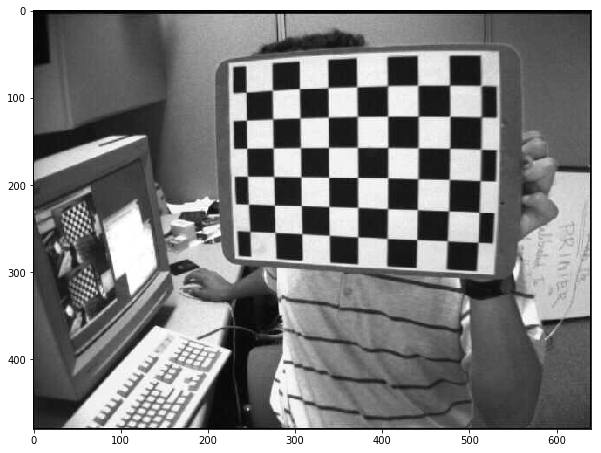

In [85]:
path = 'cal_images/left*.jpg'
images = get_images(path, gray=True)
plt.imshow(images[0], cmap='gray');

In [86]:
# create a calibration instance called cal
cal = CameraCalibration(Markers.checkerboard, marker_size=(9, 6))

# so we know a little bit about the camera, so
# start off the algorithm with a simple guess
h,w = images[0].shape[:2]
f = max(h,w)  # focal length is a function of image size in pixels
K = np.array([
    [f,0,w//2],
    [0,f,h//2],
    [0,0,1]
])

# calibrate using the images and the 9x6 checkerboard
# Note: 9x6 refers to the intersections, not the boxes
rms, M, d, rv, tv, opts, ipts = cal.calibrate(images)

Images: 13 @ (480, 640)
Markers.checkerboard (9, 6)
----------------------------------------
[0] + found 54.0 of 54 corners
[1] + found 54.0 of 54 corners
[2] + found 54.0 of 54 corners
[3] + found 54.0 of 54 corners
[4] + found 54.0 of 54 corners
[5] + found 54.0 of 54 corners
[6] + found 54.0 of 54 corners
[7] + found 54.0 of 54 corners
[8] + found 54.0 of 54 corners
[9] + found 54.0 of 54 corners
[10] + found 54.0 of 54 corners
[11] + found 54.0 of 54 corners
[12] + found 54.0 of 54 corners
RMS error: 0.19543358784937975
----------------------------------------


The resulting camera info shows a low level of distortion, so the effect with and without the correction will be small to the human eye. However, for computer vision work, it could make a difference.

If we print out the camera matrix:

In [87]:
print('Camera Matrix:\n', M)
print('Focal Length (fx,fy) = ({:.0f}, {:.0f})'.format(M[0][0],M[1][1]))
print('Principle Point (cx,cy) = ({:.0f}, {:.0f})'.format(M[0][2],M[1][2]))

Camera Matrix:
 [[532.8271074    0.         342.48678426]
 [  0.         532.94588623 233.85594818]
 [  0.           0.           1.        ]]
Focal Length (fx,fy) = (533, 533)
Principle Point (cx,cy) = (342, 234)


Mean reprojection error: 0.0264 [px]


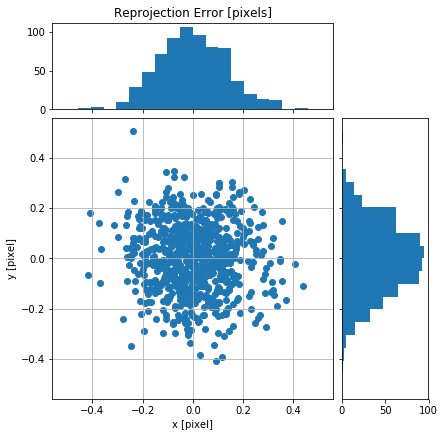

In [89]:
e, ex, ey = cal.calculateReprojectionError(ipts,opts,rv,tv,M,d)
print("Mean reprojection error: {:.4f} [px]".format(e))
errorhistogram(ex,ey)

## Undistort Image

Now let's read back in an image and use the calibration matrix to undistort it.

In [93]:
def undistort(image, mtx, dist, alpha=0.5):
    """
    image: an image
    alpha = 0: returns undistored image with minimum unwanted pixels (image
                pixels at corners/edges could be missing)
    alpha = 1: retains all image pixels but there will be black to make up
                for warped image correction
    """
    h,w = image.shape[:2]
    # Adjust the calibrations matrix
    # alpha=0: returns undistored image with minimum unwanted pixels 
    #          (image pixels at corners/edges could be missing)
    # alpha=1: retains all image pixels but there will be black to 
    #          make up for warped image correction
    # returns new cal matrix and an ROI to crop out the black edges
    newcameramtx, _ = cv2.getOptimalNewCameraMatrix(mtx, dist, (w, h), alpha)
    # undistort
    ret = cv2.undistort(image, mtx, dist, None, newcameramtx)
    return ret

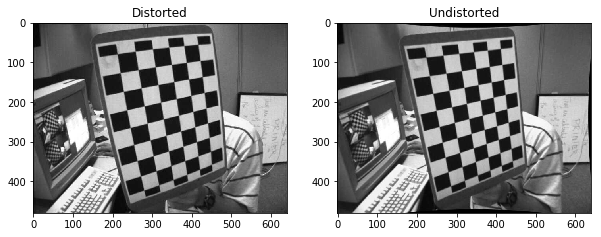

In [94]:
# read in a grayscale image
image = images[12]
dst = undistort(image, M, d)

plt.subplot(1,2,1)
plt.imshow(image, cmap='gray');
plt.title('Distorted')

plt.subplot(1,2,2)
plt.imshow(dst, cmap='gray');
plt.title('Undistorted');

Hopefully you can see the warping in the middle of the image is gone in the right side. Cameras are made much better now, than they use to be, so for a lot of single camera applications this is not necessary. However, for stereo vision (2 or more cameras) or some of the 3D work, it is necessary to calibrate your cameras.

In [96]:
# def drawAxes(img, corners, imgpts):
#     corner = tuple(corners[0].ravel())
#     img = cv2.line(img, corner, tuple(imgpts[0].ravel()), (255,0,0), 5)
#     img = cv2.line(img, corner, tuple(imgpts[1].ravel()), (0,255,0), 5)
#     img = cv2.line(img, corner, tuple(imgpts[2].ravel()), (0,0,255), 5)
#     return img

In [95]:
# i=0
# im=drawAxes(images[i].copy(), opts[i], ipts[i])
# plt.imshow(im, cmap='gray')

In [92]:
# errorhistogram(np.random.randn(1000), np.random.randn(1000))  # this is a test


-----------

<a rel="license" href="http://creativecommons.org/licenses/by-sa/4.0/"><img alt="Creative Commons License" style="border-width:0" src="https://i.creativecommons.org/l/by-sa/4.0/88x31.png" /></a><br />This work is licensed under a <a rel="license" href="http://creativecommons.org/licenses/by-sa/4.0/">Creative Commons Attribution-ShareAlike 4.0 International License</a>.